<h1>Polynomial Regression</h1>
<p>
    Models are generated using <a href="https://scikit-learn.org/stable/">scikit-learn.</a>
    <br/><br/>
    Polynomial regression essentially tries to draw a line of best fit over the training dataset; it then uses the line to predict datapoints.
</p>

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as ma
import operator

%matplotlib inline

In [141]:
def get_csv(path: str) -> pd.DataFrame:
    
    df = pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price'})

    return df


def MAPE(pred, real) -> float:
    return np.mean(abs(1 - (pred / real)))


def RMSE(pred, real) -> float:
    return np.sqrt(np.mean((real - pred) ** 2))
    

def MSE(pred, real) -> float:
    return np.mean((real - pred) ** 2)


def plot_graph(*args, title: str = None, colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], **kwargs) -> None:

    plt.figure(figsize = (20, 6))
    number_of_graph = 0
    
    if title is not None:
        plt.title(title)

    for arg in args:
        plt.plot(arg, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    for kw in kwargs:
        plt.plot(kwargs[kw], label = kw, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    if len(kwargs) > 0:
        plt.legend(loc = 'best')

    plt.show()

In [142]:
df_ada = get_csv('./data/cardano.csv')

In [143]:
x_train_ada = df_ada.index[:ma.floor(df_ada.shape[0] * 0.7)]
y_train_ada = df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)]
x_test_ada = df_ada.index[ma.floor(df_ada.shape[0] * 0.7):]
y_test_ada = df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]

In [144]:
polynomial_features_ada = PolynomialFeatures(degree = 3)
model_ada = LinearRegression()
model_ada.fit(polynomial_features_ada.fit_transform(x_train_ada.to_numpy()[:, None]), y_train_ada)
ada_pred = pd.Series(model_ada.predict(polynomial_features_ada.fit_transform(x_test_ada.to_numpy()[:, None])), index = y_test_ada.index)
ada_prediction_curve = pd.Series(model_ada.predict(polynomial_features_ada.fit_transform(df_ada.index.to_numpy()[:, None])), index = df_ada.index)

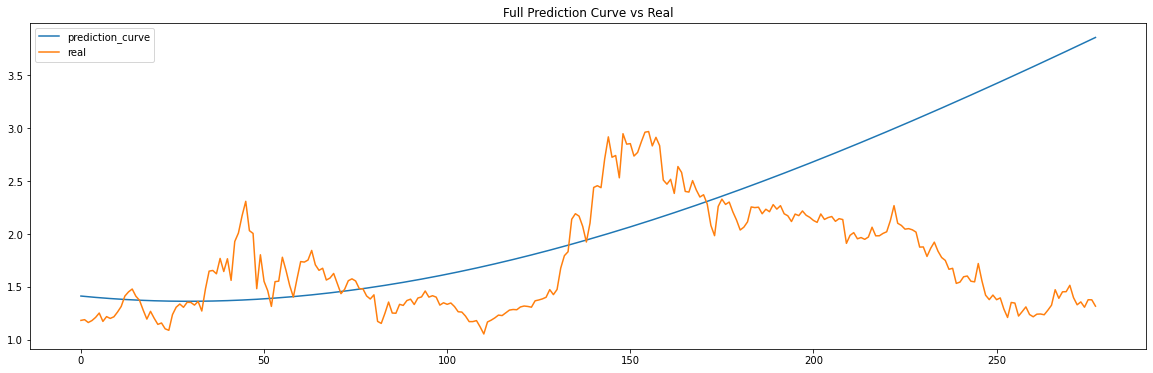

In [145]:
plot_graph(title = 'Full Prediction Curve vs Real', prediction_curve = ada_prediction_curve, real = df_ada['price'])

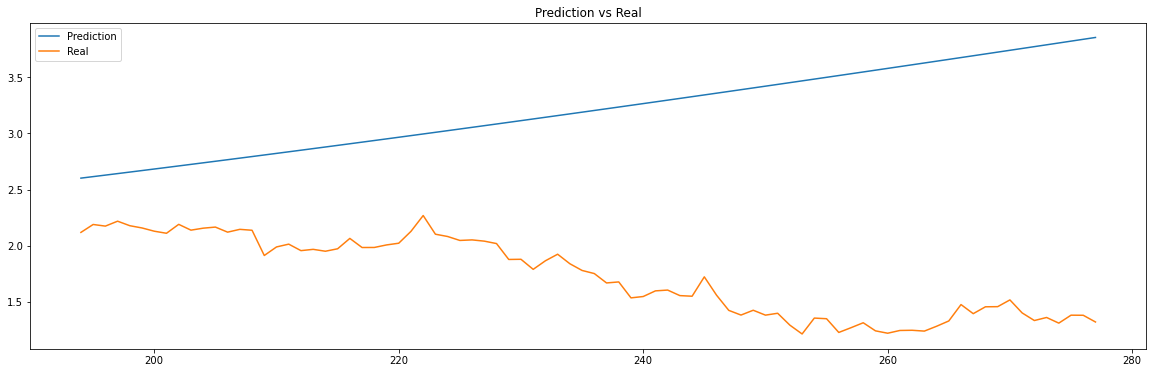

In [146]:
plot_graph(title = 'Prediction vs Real', Prediction = ada_pred, Real = y_test_ada)

In [147]:
MAPE(ada_pred, y_test_ada)

0.9766963888270874

---

<h3>Rolling Forecast</h3>

In [148]:
def rolling_forecast(df: pd.DataFrame, degree: int = 2, window: int = 7, test_ratio: float = 0.3) -> pd.DataFrame:

    polynomial_features = PolynomialFeatures(degree = degree)
    model = LinearRegression()
    x_test = df.index[ma.floor(df.shape[0] * (1 - test_ratio)):]
    result = pd.DataFrame(columns = ['date', 'pred', 'real'])

    for i in x_test:
        x_train = polynomial_features.fit_transform(df.index[i - window:i].to_numpy()[:, None])
        y_train = df['price'][i - window:i]

        model.fit(x_train, y_train)
        pred = model.predict(polynomial_features.fit_transform([[i]]))[0]
        result.loc[i] = {'date': df.loc[i]['date'],'pred': pred, 'real': df.loc[i]['price']}

    return result.set_index('date')

In [149]:
ada_rolling_1 = rolling_forecast(df_ada, 1)
ada_rolling_2 = rolling_forecast(df_ada, 2)

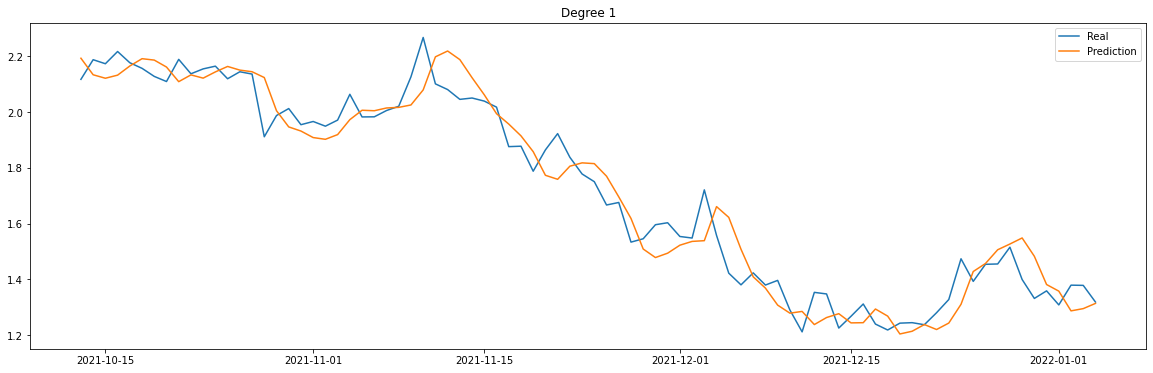

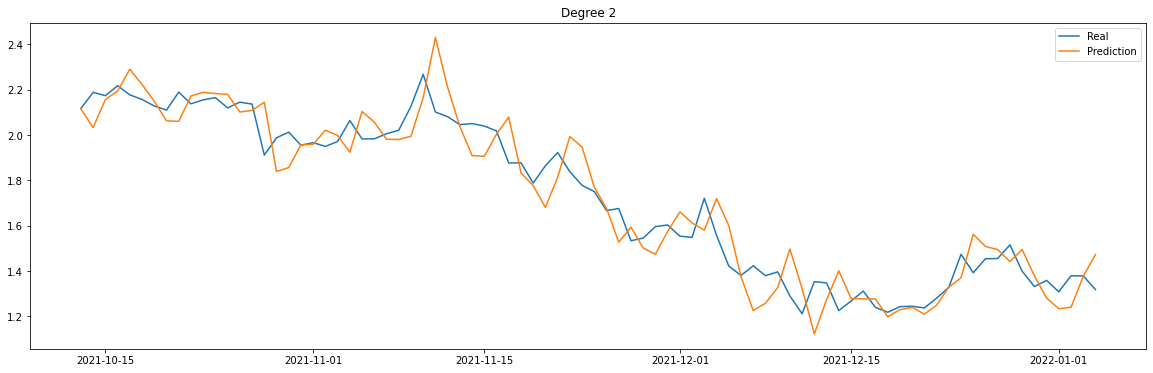

In [150]:
plot_graph(title = 'Degree 1', Real = ada_rolling_1['real'], Prediction = ada_rolling_1['pred'])
plot_graph(title = 'Degree 2',Real = ada_rolling_2['real'], Prediction = ada_rolling_2['pred'])

In [151]:
print(MAPE(ada_rolling_1['pred'], ada_rolling_1['real']))
print(MAPE(ada_rolling_2['pred'], ada_rolling_2['real']))

0.03890907984694082
0.051377842326672016


---

<h3>ETH</h3>

In [152]:
df_eth = get_csv('./data/ethereum.csv')

In [153]:
eth_rolling = rolling_forecast(df_eth, degree = 1)

0.04870844221890121


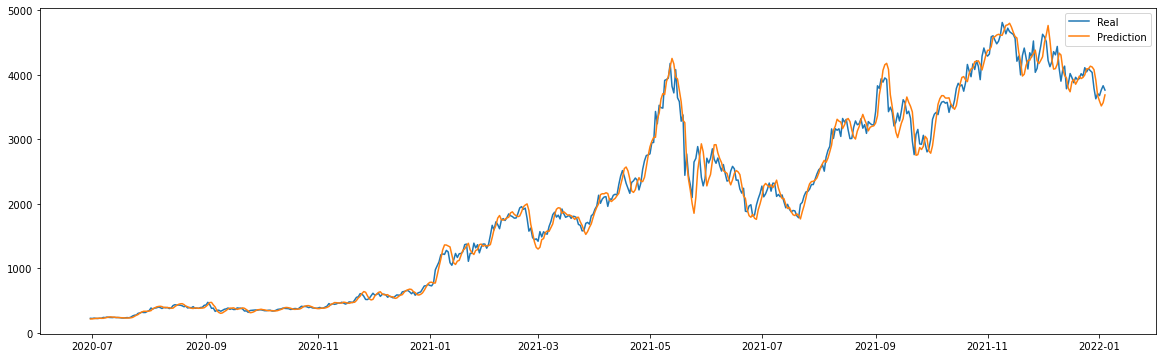

In [154]:
print(MAPE(eth_rolling['pred'], eth_rolling['real']))
plot_graph(Real = eth_rolling['real'], Prediction = eth_rolling['pred'])

---

<h3>DOGE</h3>

In [160]:
df_doge = get_csv('./data/dogecoin.csv')[775:].reset_index().drop(columns = ['index'])

In [161]:
doge_rolling = rolling_forecast(df_doge, 1)

0.04467044118940917


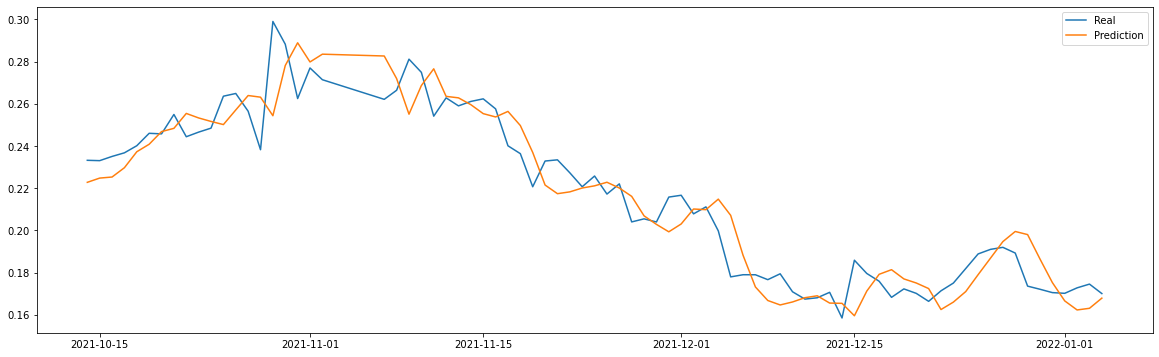

In [162]:
print(MAPE(doge_rolling['pred'], doge_rolling['real']))
plot_graph(Real = doge_rolling['real'], Prediction = doge_rolling['pred'])

---

<h3>SOL</h3>

In [163]:
df_sol = get_csv('./data/solana.csv')

In [174]:
sol_rolling = rolling_forecast(df_sol, 1)

0.04682763333321861


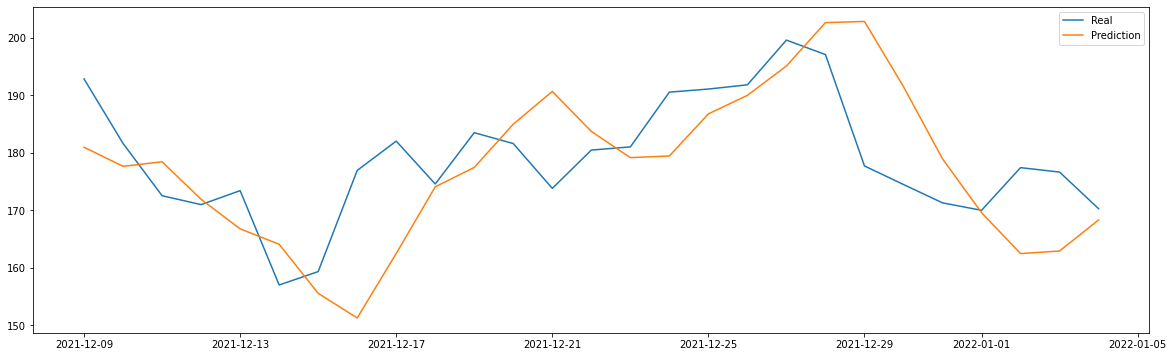

In [175]:
print(MAPE(sol_rolling['pred'], sol_rolling['real']))
plot_graph(Real = sol_rolling['real'], Prediction = sol_rolling['pred'])